In [1]:
#Run this cell if any import errors occur
#! pip install datasets transformers
#! pip install -U scikit-learn

In [2]:
#Collecting all imports
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForMultipleChoice, TrainingArguments, Trainer
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch
from sklearn.metrics import f1_score
import numpy as np

import transformers

print(transformers.__version__)
#Transformers should be at least 4.11.0 required!

C:\Users\braph\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


4.32.1


C:\Users\braph\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


We must now load the dataset from our local JSON files. 

In [3]:
#Load the dataset as train, validation, and test.
#We use the dev data as validation.

datasets = load_dataset("json", data_files={'train':'Project/QQA_Data/QQA_train.json', 
                                           'validation':'Project/QQA_Data/QQA_dev.json', 
                                           'test':'Project/QQA_Data/QQA_test.json'})

#Printing the dataset contents
print('Q: ' + datasets['train'][0]['question'])
print('O1: ' + datasets['train'][0]['Option1'])
print('O2: ' + datasets['train'][0]['Option2'])
print('A: ' + datasets['train'][0]['answer'])

Q: The ranger and the rustler both were riding horses that galloped at the same speed.  The rustler left at 01:00 where as the ranger left at 0500 hours. Who has traveled further?? 
O1: the ranger
O2: the rustler
A: Option 2


In [4]:
#Print dataset structure
datasets

DatasetDict({
    train: Dataset({
        features: ['question_sci_10E_char', 'question_mask', 'Option1', 'Option2', 'type', 'question_sci_10E', 'answer', 'question', 'question_char'],
        num_rows: 564
    })
    validation: Dataset({
        features: ['question_sci_10E_char', 'question_mask', 'Option1', 'Option2', 'type', 'question_sci_10E', 'answer', 'question', 'question_char'],
        num_rows: 81
    })
    test: Dataset({
        features: ['question_sci_10E_char', 'question_mask', 'Option1', 'Option2', 'type', 'question_sci_10E', 'answer', 'question', 'question_char'],
        num_rows: 162
    })
})

The imported data is of the form:

{"question": "Jame's mother has a photo of Jane standing at a height of 14 inches, whereas a mountain appears to have height of 26 cm. It looks that way because? ", "Option1": "the mountain was farther away", "Option2": "Jane was farther away", "answer": "Option 2", "type": "Type_3", "question_sci_10E": "Jame's mother has a photo of Jane standing at a height of 1.4000000000E+01 inches, whereas a mountain appears to have height of 2.6000000000E+01 cm. It looks that way because? ", "question_char": "Jame's mother has a photo of Jane standing at a height of 1 4 inches, whereas a mountain appears to have height of 2 6 cm. It looks that way because? ", "question_sci_10E_char": "Jame's mother has a photo of Jane standing at a height of 1 . 4 0 0 0 0 0 0 0 0 0 E + 0 1 inches, whereas a mountain appears to have height of 2 . 6 0 0 0 0 0 0 0 0 0 E + 0 1 cm. It looks that way because? ", "question_mask": "Jame's mother has a photo of Jane standing at a height of [Num] inches, whereas a mountain appears to have height of [Num] cm. It looks that way because? "

In [5]:
#Let's get rid of the other columns
datasets = datasets.remove_columns(['question_char', 'question_sci_10E',
                         'question_sci_10E_char',
                         'question_mask', 'type',])

#We now only have a question, answer, and 2 options.

In [6]:
#Renaming for compatibility later
datasets = datasets.rename_column('answer', 'label')

For evaluation, see https://huggingface.co/spaces/evaluate-metric/accuracy

For fine-tuning, see: https://huggingface.co/docs/transformers/en/training#train-with-pytorch-trainer

For handing multiple choice, see https://huggingface.co/docs/transformers/en/tasks/multiple_choice


In [7]:
#Set correct answer to an integer. 

def set_labels(example):
    #print(example)
    example["label"] = int(example["label"][-1]) - 1
    return example

datasets = datasets.map(set_labels)

In [8]:
datasets["train"][30]

{'Option1': 'race car',
 'Option2': 'pickup',
 'label': 1,
 'question': 'A race car and a pickup both drove on the highway at the same speed. The driver of the race car got tired and parked after 29 mins, while the driver of the pickup ran for 43 mins. Which vehicle ultimately went the greater distance?? '}

In [9]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
tokenizer("This is a boat.", "This is a plane.")

{'input_ids': [101, 2023, 2003, 1037, 4049, 1012, 102, 2023, 2003, 1037, 4946, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
ending_names = ["Option1", "Option2"]

def preprocess_function(examples):
    # Repeat each first sentence two times to go with the two possibilities of second sentences.
    first_sentences = [[context] * 2 for context in examples["question"]]
    # Grab all second sentences possible for each context.
    question_headers = examples["question"]
    second_sentences = [[f"{header} {examples[end][i]}" for end in ending_names] for i, header in enumerate(question_headers)]
    
    # Flatten everything
    first_sentences = sum(first_sentences, [])
    second_sentences = sum(second_sentences, [])

    # Tokenize
    tokenized_examples = tokenizer(first_sentences, second_sentences, truncation=True)
    # Un-flatten
    return {k: [v[i:i+2] for i in range(0, len(v), 2)] for k, v in tokenized_examples.items()}

In [11]:
examples = datasets["train"][:5]
features = preprocess_function(examples)
print(len(features["input_ids"]), len(features["input_ids"][0]), [len(x) for x in features["input_ids"][0]])

5 2 [89, 90]


In [12]:
idx = 3
[tokenizer.decode(features["input_ids"][idx][i]) for i in range(2)]

['[CLS] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? [SEP] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? the tank will speed up faster than the toy car [SEP]',
 '[CLS] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? [SEP] a tank weighs around 63 tons. a toy car weighs 1. 5 kg. because of this? the toy car will speed up faster than the tank [SEP]']

In [13]:
#encoded_datasets = datasets.map(preprocess_function, batched=True)
#print(encoded_datasets)

In [14]:
model = AutoModelForMultipleChoice.from_pretrained('bert-base-uncased')

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [[{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        
        # Un-flatten
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        # Add back labels
        batch["labels"] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [16]:
#Testing stuff. Be sure to create encoded_datasets if you're running this. 
#accepted_keys = ["input_ids", "attention_mask", "label"]
#features = [{k: v for k, v in encoded_datasets["train"][i].items() if k in accepted_keys} for i in range(10)]
#batch = DataCollatorForMultipleChoice(tokenizer)(features)
#[tokenizer.decode(batch["input_ids"][8][i].tolist()) for i in range(2)]

In [17]:
#Use the F1 score metric to evaluate our predictions. 

#Old evaluator.
'''
def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    preds = np.argmax(predictions, axis=1)
    return {"accuracy": (preds == label_ids).astype(np.float32).mean().item()}
'''

#New evaluator.
def compute_metrics(eval_predictions):
    predictions, label_ids = eval_predictions
    
    preds = np.argmax(predictions, axis=1)

    return {"accuracy": f1_score(label_ids, preds, average='micro')}

In [18]:
# A cell to reset the dataset if/when problems occur with it.
# Probably good to run this if you ran the above cells, since there's a lot of testing stuff for one model

datasets = load_dataset("json", data_files={'train':'Project/QQA_Data/QQA_train.json', 
                                           'validation':'Project/QQA_Data/QQA_dev.json', 
                                           'test':'Project/QQA_Data/QQA_test.json'})

#Printing the dataset contents
print('Q: ' + datasets['train'][0]['question'])
print('O1: ' + datasets['train'][0]['Option1'])
print('O2: ' + datasets['train'][0]['Option2'])
print('A: ' + datasets['train'][0]['answer'])

#Let's get rid of the other columns
datasets = datasets.remove_columns(['question_char', 'question_sci_10E',
                         'question_sci_10E_char',
                         'question_mask', 'type',])

#We now only have a question, answer, and 2 options.

datasets = datasets.rename_column('answer', 'label')

def set_labels(example):
    #print(example)
    example["label"] = int(example["label"][-1]) - 1
    return example

datasets = datasets.map(set_labels)

print(datasets)

Q: The ranger and the rustler both were riding horses that galloped at the same speed.  The rustler left at 01:00 where as the ranger left at 0500 hours. Who has traveled further?? 
O1: the ranger
O2: the rustler
A: Option 2
DatasetDict({
    train: Dataset({
        features: ['Option1', 'Option2', 'label', 'question'],
        num_rows: 564
    })
    validation: Dataset({
        features: ['Option1', 'Option2', 'label', 'question'],
        num_rows: 81
    })
    test: Dataset({
        features: ['Option1', 'Option2', 'label', 'question'],
        num_rows: 162
    })
})


In [19]:
#Training function. Duplicate and change model name for other models.

modelName = ""

def autoTrain(model_name = 'bert-base-uncased', batch_size = 16):
    global model
    global tokenizer
    global modelName
    modelName = model_name
    model = AutoModelForMultipleChoice.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    
    encoded_datasets = datasets.map(preprocess_function, batched=True)
    
    args = TrainingArguments(
        f"{model_name}-finetuned-QQA",
        evaluation_strategy = "epoch",
        learning_rate=5e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=3,
        weight_decay=0.01,
    )
    
    trainer = Trainer(
        model,
        args,
        train_dataset=encoded_datasets["train"],
        eval_dataset=encoded_datasets["validation"],
        tokenizer=tokenizer,
        data_collator=DataCollatorForMultipleChoice(tokenizer),
        compute_metrics=compute_metrics,
    )
    
    trainer.train()


In [20]:
#Cell for testing
print(datasets["test"])

Dataset({
    features: ['Option1', 'Option2', 'label', 'question'],
    num_rows: 162
})


In [21]:
# Example prediction

prompt = "I have 5 bagels and Joe has 2. Who has more bagels?"
candidate1 = "Me"
candidate2 = "Joe"


inputs = tokenizer([[prompt, candidate1], [prompt, candidate2]], return_tensors="pt", padding=True)
labels = torch.tensor(0).unsqueeze(0)
outputs = model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels=labels)
logits = outputs.logits

predicted_class = logits.argmax().item()
predicted_class

#Note that it will output a 0 or 1, where 0 = Option 1 and 1 = Option 2

1

In [22]:
#Eval the most recently trained model
def evaluate_hf_model():

    global model
    global tokenizer

            
    predictions = []
    references = []

    # Get predictions, and save corresponding reference (if we were using the whole dataset, we wouldn't need this step)
    for ex in datasets["test"]:

        #Based on the above cell, get 
        prompt = ex['question']
        candidate1 = ex['Option1']
        candidate2 = ex['Option2']
        
        inputs = tokenizer([[prompt, candidate1], [prompt, candidate2]], return_tensors="pt", padding=True)
        labels = torch.tensor(0).unsqueeze(0)
        outputs = model(**{k: v.unsqueeze(0) for k, v in inputs.items()}, labels=labels)
        logits = outputs.logits
        
        predicted_class = logits.argmax().item()
        predicted_class


        predictions.append(predicted_class)
        references.append(ex['label'])

    # Compute metrics
    global modelName
    print('Performance of {} : {}'.format(modelName, f1_score(references, predictions, average='micro')))

In [23]:
def trainAndEval(model_name, batch_size):
    autoTrain(model_name, batch_size)
    #eval_hf_model evaluates whatever model we just trained because of global variables. 
    #As such we have it eval after training.
    evaluate_hf_model()

In [24]:
#Training and evaluating bert-base-uncased
trainAndEval("bert-base-uncased", 16)

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693407,0.518519
2,No log,0.693395,0.506173
3,No log,0.692629,0.543210


Performance of bert-base-uncased : 0.49382716049382713


In [25]:
trainAndEval("cardiffnlp/twitter-roberta-base-sentiment-latest", 16)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

C:\Users\braph\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\braph\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment-latest. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.698733,0.530864
2,No log,0.721231,0.580247
3,No log,0.750790,0.567901


Performance of cardiffnlp/twitter-roberta-base-sentiment-latest : 0.5185185185185185


In [26]:
trainAndEval("distilbert/distilbert-base-uncased", 16)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

C:\Users\braph\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\braph\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693211,0.444444
2,No log,0.693783,0.432099
3,No log,0.694439,0.419753


Performance of distilbert/distilbert-base-uncased : 0.4876543209876543


In [27]:
trainAndEval("dccuchile/bert-base-spanish-wwm-cased", 16)

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

C:\Users\braph\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\braph\.cache\huggingface\hub\models--dccuchile--bert-base-spanish-wwm-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693796,0.407407
2,No log,0.693794,0.370370
3,No log,0.693537,0.382716


Performance of dccuchile/bert-base-spanish-wwm-cased : 0.5493827160493827


In [28]:
trainAndEval('deepset/roberta-base-squad2', 16)

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

C:\Users\braph\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\braph\.cache\huggingface\hub\models--deepset--roberta-base-squad2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.weight', 'classifier.bias', 'classifier.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.694271,0.493827
2,No log,0.693199,0.580247
3,No log,0.692599,0.555556


Performance of deepset/roberta-base-squad2 : 0.49382716049382713


In [29]:
trainAndEval('Intel/dynamic_tinybert', 16)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

C:\Users\braph\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\braph\.cache\huggingface\hub\models--Intel--dynamic_tinybert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForMultipleChoice were not initialized from the model checkpoint at Intel/dynamic_tinybert and are newly initialized: ['classifier.bias', 'bert.pooler.dense.bias', 'classifier.weight', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693223,0.493827
2,No log,0.693255,0.432099
3,No log,0.693407,0.419753


Performance of Intel/dynamic_tinybert : 0.5


In [30]:
trainAndEval('distilbert/distilbert-base-cased-distilled-squad', 16)

Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert/distilbert-base-cased-distilled-squad and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693228,0.469136
2,No log,0.695521,0.407407
3,No log,0.697462,0.407407


Performance of distilbert/distilbert-base-cased-distilled-squad : 0.47530864197530864


In [31]:
trainAndEval('FabianWillner/distilbert-base-uncased-finetuned-squad', 16)

Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at FabianWillner/distilbert-base-uncased-finetuned-squad and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/564 [00:00<?, ? examples/s]

Map:   0%|          | 0/81 [00:00<?, ? examples/s]

Map:   0%|          | 0/162 [00:00<?, ? examples/s]

C:\Users\braph\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.693158,0.407407
2,No log,0.693034,0.604938
3,No log,0.693060,0.555556


Performance of FabianWillner/distilbert-base-uncased-finetuned-squad : 0.4691358024691358


# Comparison:

The models that we evaluated were the following:

Baseline:

The baseline model, bert-base-uncased, and its variants. Most are designed for masked langauge modeling with similar training data, so that the only major differences are the architecture of the transformer. Some, however, use different training data. 

- bert-base-uncased, trained on a large corpus of unlabeled data with the objective of masked language modeling and next sentence prediction. Because there are no "special" features in this version of BERT, and because of its ubiquity, it is used as a baseline for other models to be compared to in this project. https://huggingface.co/google-bert/bert-base-uncased
- distilbert-base-uncased, trained on the same data as the regular bert-base-uncased. It is smaller and faster than regular BERT, and provides an example of how reducing the number of parameters (from 110M to 67M) affects a model's ability to preform QQA. Notably, distilbert trained faster, at 0.18 it/s instead of the regular BERT's 0.08 it/s. https://huggingface.co/distilbert/distilbert-base-uncased
- bert-base-spanish-wwm-cased, trained on a large corpus of Spanish data. Used as an example of how training data may affect a model's ability to preform QQA. Notably, fine-tuning this model took much more time than regular BERT, with it training at a rate of 0.03 it/s. https://huggingface.co/dccuchile/bert-base-spanish-wwm-cased

Sentiment Analysis Models:

Models designed for sentiment analysis. 

- cardiffnlp/twitter-roberta-base-sentiment-latest, a RoBERTa-base model trained on ~124M tweets from January 2018 to December 2021, and finetuned for sentiment analysis with the TweetEval benchmark. As this is trained for sentiment analysis, it'll provide insight into how being fine-tuned for another task beforehand affects a model's ability to preform QQA. It will also serve as the baseline for the sentiment analysis models as it contains no other notable features.
- https://huggingface.co/siebert/sentiment-roberta-large-english (In progress)
- https://huggingface.co/MilaNLProc/feel-it-italian-sentiment (In progress)


All models were fine-tuned on the QQA dataset for 3 epochs with a batch size of 16, and evaluated using the evaluate_hf_model() function afterward. For evaluation, the scikit F1 micro score was used. 

In [38]:
#Storing the name and accuracy to avoid having to redo everything all the time.
#Also good for graphing. 

#Names are shortened to be readable on the graphs.
modelNameAcc = [
    #Baseline, masked language
    ["bert", 0.5185185185185185],
    ["distilbert", 0.49382716049382713],
    ["bert-base-spanish", 0.5432098765432098],

    
    #Sentiment Analysis
    ["twitter-roberta", 0.47530864197530864]
]

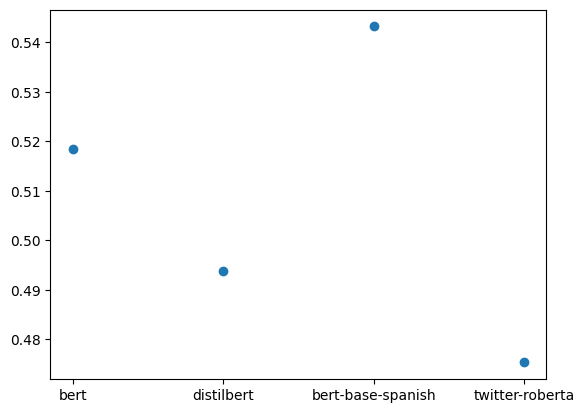

In [39]:
#Plot model names, accuracies, on a graph for easy comparison

import matplotlib.pyplot as plt 

#X points for plotting
xpoints = np.linspace(1, len(modelNameAcc), len(modelNameAcc))
ypoints = np.zeros(len(modelNameAcc))

countModels = 0
names = []
for k in range(len(modelNameAcc)):
    model, acc = modelNameAcc[k]
    countModels += 1
    ypoints[k] = acc
    names.append(model)

#Set plot and plot
plt.xticks(xpoints, names)
plt.scatter(xpoints, ypoints)
plt.show()